# Predict on a directory of Audio recordings
For each file
* Identify time stamps of prevalant animal sounds
* Capture the probability output


## Using PANN SED model

See: 
* PANN source https://github.com/qiuqiangkong/audioset_tagging_cnn/

* https://github.com/FaithKaixuan/German_Birdcall_Classification_PANNs_CNNseries/blob/master/Results%20Analysis/Germany_Birdcall_Engine_nonemixup.ipynb

* Usage Example https://github.com/yinkalario/Sound-Event-Detection-AudioSet

Other option not explored
* https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection/comments#962915

Fixes
* Amp to DB results may vary with batch size since the batch is used for normalizing.  Affects inference.  need to check - see https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection/comments#973439



* Use some Sound Event Detection - polyphonic
* Use image transformers - see guy at Kaggle bird competition
* Use multiple networks at different time scales and combine results
* Recurrent/transformer?
* change background noises
* use stereo signals to help - phase info
* Time of Day?
* Use wavelets

* Change validation so that it makes a class decision based on the whole validation sample, not just the 5 sec clip.

* I added 0.25 of class for "no_call" to each training data point to help with training.

* take out the 'interpolation' and 'padding' of framewise output.  It just increases data size without any value.  Add the timestamp to the output here instead.  

https://pywavelets.readthedocs.io/en/latest/index.html

https://pytorch-wavelets.readthedocs.io/en/latest/readme.html
https://www.researchgate.net/publication/242415506_BIRD_SOUND_CLASSIFICATION_AND_RECOGNITION_USING_WAVELETS_KLASIFIKACIJA_IN_PREPOZNAVANJE_PTIOEJIH_GLASOV_S_POMOOEJO_VALOEKOV

https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

https://github.com/tomrunia/PyTorchWavelets  - 1D wavelets in pytorch


* Related problem - human activity recognition https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/




## Project setup

In [1]:
from pathlib import Path
import os

project_base = "/media/SSD/Sound Detection/"
results_folder = "Results"
data_folder = "birdclef-2021/train_short_audio"
model_folder = "models"

model_name_base = "pann-test-other"

In [2]:
data_path = Path(project_base)
print(data_path)

/media/SSD/Sound Detection


### Experiment documentation

In [3]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);



<IPython.core.display.Javascript object>

In [4]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /Sound/Predict recordings-PANN-SED-1A-other animals.ipynb


In [5]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder, nb_path.stem)
print(result_path)
os.makedirs(result_path, exist_ok=True)

/Sound/Predict recordings-PANN-SED-1A-other animals.ipynb
/media/SSD/Sound Detection/Results/Predict recordings-PANN-SED-1A-other animals


In [6]:
model_out_path = Path(project_base) / model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/Sound Detection/models


In [7]:
#!wget -P "/media/SSD/Sound Detection/models" https://zenodo.org/record/3987831/files/Cnn14_DecisionLevelAtt_mAP%3D0.425.pth?download=1

## Start here

In [8]:
#Improved CUDA debugging
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [9]:
import torch


In [10]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print("total=",t)
print("reserved=",r)
print("allocated=",a)
print("free=",f)

total= 8366784512
reserved= 0
allocated= 0
free= 0


In [11]:

import pandas as pd
import torchaudio
import numpy as np

Ideas
* Convert dataframe into sqlite in memory database for faster training
* Convert dataframe to numpy array for faster training


In [12]:
# from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#preparing-data-and-utility-functions-skip-this-section

from IPython.display import Audio, display
#import librosa
import matplotlib.pyplot as plt


def play_audio(waveform, sample_rate):
    if type(waveform) != np.ndarray:
        waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError(
            "Waveform with more than 2 channels are not supported.")


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")
        print()
        print(waveform)
        print()


def plot_waveform(waveform,
                  sample_rate,
                  title="Waveform",
                  xlim=None,
                  ylim=None):
    if type(waveform) != np.ndarray:
        waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, figsize=(12, 6))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1, color="#A300F9")
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(12, 6))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate,)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(spec,
                     title=None,
                     ylabel='freq_bin',
                     aspect='auto',
                     xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    #im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    im = axs.imshow(torchaudio.functional.amplitude_to_DB(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

## Handle Metadata

In [13]:
df = pd.read_csv('/media/SSD/Sound Detection/combined_train_metadata.csv',index_col=[0])
df1 = pd.read_csv('/media/SSD/Sound Detection/other-animals/american-toad/train_metadata.csv',index_col=[0])
df2 = pd.read_csv('/media/SSD/Sound Detection/other-animals/chipmunk/train_metadata.csv',index_col=[0])
df3 = pd.read_csv('/media/SSD/Sound Detection/other-animals/coyote/train_metadata.csv',index_col=[0])
df4 = pd.read_csv('/media/SSD/Sound Detection/other-animals/green-frog/train_metadata.csv',index_col=[0])
df5 = pd.read_csv('/media/SSD/Sound Detection/other-animals/spring-peeper/train_metadata.csv',index_col=[0])
df6 = pd.read_csv('/media/SSD/Sound Detection/other-animals/western-chorus-frog/train_metadata.csv',index_col=[0])
df7 = pd.read_csv('/media/SSD/Sound Detection/other-animals/wood-frog/train_metadata.csv',index_col=[0])
df = pd.concat([df, df1, df2, df3, df4, df5, df6, df7], ignore_index=True, sort=True)                  

/media/SSD/conda_env/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (2,6,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Handle class labels

In [14]:
keys = pd.read_csv('/media/SSD/Sound Detection/label_metadata.csv',index_col=[0])
keys1 = pd.read_csv('/media/SSD/Sound Detection/other-animals/american-toad/key.csv',index_col=[0])
keys2 = pd.read_csv('/media/SSD/Sound Detection/other-animals/chipmunk/key.csv',index_col=[0])
keys3 = pd.read_csv('/media/SSD/Sound Detection/other-animals/coyote/key.csv',index_col=[0])
keys4 = pd.read_csv('/media/SSD/Sound Detection/other-animals/green-frog/key.csv',index_col=[0])
keys5 = pd.read_csv('/media/SSD/Sound Detection/other-animals/spring-peeper/key.csv',index_col=[0])
keys6 = pd.read_csv('/media/SSD/Sound Detection/other-animals/western-chorus-frog/key.csv',index_col=[0])
keys7 = pd.read_csv('/media/SSD/Sound Detection/other-animals/wood-frog/key.csv',index_col=[0])
keys = pd.concat([keys, keys1, keys2, keys3, keys4, keys5, keys6, keys7], ignore_index=True)

In [15]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,):
    display(keys)

common_name primary_label  \
0                  Acadian Flycatcher        acafly   
1                    Acorn Woodpecker        acowoo   
2                    Alder Flycatcher        aldfly   
3                     American Avocet        ameavo   
4                       American Crow        amecro   
5                  American Goldfinch        amegfi   
6                    American Kestrel        amekes   
7                      American Pipit        amepip   
8                   American Redstart        amered   
9                      American Robin        amerob   
10                    American Wigeon        amewig   
11              American Tree Sparrow        amtspa   
12                   Andean Solitaire       andsol1   
13                 Anna's Hummingbird        annhum   
14            Ash-throated Flycatcher        astfly   
15                  Azara's Spinetail       azaspi1   
16               Bay-breasted Warbler        babwar   
17                         Bald Eagle        baleag   
18                   Baltimore Oriole        balori   
19                         Bananaquit        banana   
20                       Bank Swallow        banswa   
21                        Banded Wren       banwre1   
22                   Barred Antshrike       barant1   
23                       Barn Swallow        barswa   
24                 Band-tailed Pigeon       batpig1   
25             Blue-and-white Swallow       bawswa1   
26            Black-and-white Warbler        bawwar   
27                           Bay Wren       baywre1   
28       Black-bellied Whistling-Duck        bbwduc   
29          Black-crowned Night-Heron        bcnher   
30                  Belted Kingfisher       belkin1   
31                       Bell's Vireo        belvir   
32                      Bewick's Wren        bewwre   
33                Black-billed Magpie       bkbmag1   
34               Black-bellied Plover        bkbplo   
35               Blackburnian Warbler        bkbwar   
36             Black-capped Chickadee        bkcchi   
37              Black-headed Grosbeak        bkhgro   
38             Yellow-throated Toucan       bkmtou1   
39                 Black-necked Stilt        bknsti   
40               Blue-black Grassquit       blbgra1   
41                Black-billed Thrush       blbthr1   
42                  Black-chested Jay       blcjay1   
43               Black-capped Tanager       blctan1   
44                 Blue-headed Parrot       blhpar1   
45                       Black Phoebe        blkpho   
46              Black-striped Sparrow       blsspa1   
47                      Blue Grosbeak       blugrb1   
48                           Blue Jay        blujay   
49           Brown-crested Flycatcher        bncfly   
50               Brown-headed Cowbird        bnhcow   
51             Boat-billed Flycatcher       bobfly1   
52                   Bonaparte's Gull        bongul   
53                Boat-tailed Grackle        botgra   
54                Broad-billed Motmot       brbmot1   
55             Brown-backed Solitaire       brbsol1   
56                 Brown-capped Vireo       brcvir1   
57                 Brewer's Blackbird        brebla   
58                      Brown Creeper        brncre   
59                          Brown Jay        brnjay   
60                     Brown Thrasher        brnthr   
61               Bright-rumped Attila       brratt1   
62                  Broad-winged Hawk        brwhaw   
63               Bronze-winged Parrot       brwpar1   
64        Black-throated Blue Warbler        btbwar   
65       Black-throated Green Warbler        btnwar   
66        Black-throated Gray Warbler        btywar   
67                    Lesson's Motmot       bucmot2   
68              Blue-gray Gnatcatcher        buggna   
69                  Blue-gray Tanager        bugtan   
70                  Blue-headed Vireo        buhvir   
71                   Bullock's Oriole        bulori   
72         

In [16]:
def bird_lookup(key):
    common_name = keys["common_name"][keys.primary_label == key].item()
    scientific_name = keys["scientific_name"][keys.primary_label == key].item()
    
    return common_name, scientific_name

def bird_idn(key):
    #return BIRD_CODE[key]
    return keys.index[keys['primary_label'] == key].tolist()[0]

def bird_common(idn):
    #key = INV_BIRD_CODE[idn]
    #return bird_key["common_name"][bird_key.primary_label == key].item()
    return keys.loc[idn,"common_name"]

def bird_label(idn):
    #key = INV_BIRD_CODE[idn]
    #return bird_key["common_name"][bird_key.primary_label == key].item()
    return keys.loc[idn,"primary_label"]

In [17]:
bird_lookup('rthhum')

('Ruby-throated Hummingbird', 'Archilochus colubris')

In [18]:
bird_idn('no_call')

220

In [19]:
bird_common(220)

'No Call'

## Create a dataset

https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/

https://github.com/gskdhiman/Pytorch-Transfer-learning-Multi-Label-image-Classification/blob/master/pytorch-resnet50-starter.ipynb




In [20]:
class Dataset_from_df_seg(torch.utils.data.Dataset):
    def __init__(self, file_df, label_df,path, crop_length,segments,no_labels = False):
        self.file_df = file_df
        self.label_df = label_df
        self.path = path
        self.crop_length = crop_length
        self.segments = segments
        self.no_labels = no_labels
        self.block_size = crop_length/segments
        self.text_labels = label_df.primary_label.to_list()
        self.class_n = len(self.text_labels)
        self.class_code = {}
        for i, label in enumerate(self.text_labels):
            self.class_code[label] = i
         
        self.clip_list = {"id":[],"tstart":[]}
        for i in file_df.index:
            clips = int(file_df.loc[i,'sample_len']/crop_length)
            for c in range(clips):
                self.clip_list['id'].append(i)
                self.clip_list['tstart'].append(c*crop_length)
        
            

    def __len__(self):
        return len(self.clip_list['id'])

    def __getitem__(self, index):
        def _randint(a, b):
            return torch.randint(a, b, (1, )).item()

        f_index = self.clip_list['id'][index]
        
        
        c = self.file_df.loc[f_index]['channels']

        #need to map sample label to index


        crop_start = self.clip_list['tstart'][index]
        x, sr = torchaudio.load(self.path + "/" +
                                self.file_df.iloc[f_index]['subpath'],
                                frame_offset=crop_start,
                                num_frames=self.crop_length)
       

        target = torch.zeros(self.class_n)
        
        #### Need to handle test sets and training sets
        if self.no_labels == False:
            label = self.file_df.loc[f_index]['primary_label']
            target[self.class_code[label]] = 0.75
            target[self.class_code["no_call"]] = target[self.class_code["no_call"]] + 0.25
        
        #print("label=",label, "code=",self.class_code[label])

        return x, sr, target, index
    
    def lookup_common_name(self, index):
        f_index = self.clip_list['id'][index]
        
        bird_name = self.label_df.loc[f_index]["common_name"]
        
        return bird_name

    def lookup_key(self, class_id):
        
        bird_label = self.label_df.loc[class_id]["primary_label"]
        
        return bird_label
        

## Define the network

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# Todo

* Remove the audio to image processing from network - separate out
* do mix-up with audio signals
* deal with phase??

In [22]:
def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
            
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)

            
            
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


    
class AttBlock(nn.Module):
    def __init__(self, n_in, n_out, activation='linear', temperature=1.):
        super(AttBlock, self).__init__()
        
        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
        self.cla = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
        
        self.bn_att = nn.BatchNorm1d(n_out)
        self.init_weights()
        
    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)
         
    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2).clamp(0,1)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

        
        
def interpolate(x, ratio):
    """Interpolate data in time domain. This is used to compensate the 
    resolution reduction in downsampling of a CNN.
    
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate

    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output, frames_num):
    """Pad framewise_output to the same length as input frames. The pad value 
    is the same as the value of the last frame.

    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad

    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1 :, :].repeat(1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output

        

class Cnn14_DecisionLevelAtt(nn.Module):
    def __init__(self, classes_num):
        
        super(Cnn14_DecisionLevelAtt, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 32     # Downsampled ratio

        # Spectrogram extractor
        #self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
        #    win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
        #    freeze_parameters=True)

        # Logmel feature extractor
        #self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
        #    n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
        #    freeze_parameters=True)

        # Spec augmenter
        #self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
        #    freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(80)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.att_block = AttBlock(2048, classes_num, activation='sigmoid')
        
        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
 
    def forward(self, x, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        #x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        #x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        #print("input shape is",x.shape)
        x = x.transpose(2,3)
        #print("x shape is ",x.shape)
        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        #if self.training:
        #    x = self.spec_augmenter(x)

        # Mixup on spectrogram
        #if self.training and mixup_lambda is not None:
        #    x = do_mixup(x, mixup_lambda)
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        #print("feature extractor shape is",x.shape)
        x = torch.mean(x, dim=3)
        
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        (clipwise_output, _, segmentwise_output) = self.att_block(x)
        segmentwise_output = segmentwise_output.transpose(1, 2)
        
        # Get framewise output
        #framewise_output = interpolate(segmentwise_output, self.interpolate_ratio)
        #framewise_output = pad_framewise_output(framewise_output, frames_num)
        framewise_output = segmentwise_output
        output_dict = {'framewise_output': framewise_output, 
            'clipwise_output': clipwise_output}

        return output_dict

In [23]:
model = Cnn14_DecisionLevelAtt(classes_num=len(keys))


In [24]:
# build a new model

resample = torchaudio.transforms.Resample(32000, 48000)

spec = torchaudio.transforms.MelSpectrogram(sample_rate=48000,
                                            n_fft=768,
                                            n_mels=80,
                                            f_min=200,
                                            f_max=10000)
a_to_db = torchaudio.transforms.AmplitudeToDB()
#new_model = nn.Sequential(resample,spec,model)
new_model = nn.Sequential(resample, spec, a_to_db, model)

In [25]:
#for param in new_model.parameters():
#    param.requires_grad = False

In [26]:
new_model.cuda();

In [27]:
model_out_str = str(model_out_path/(model_name_base+"3.pth"))
new_model.load_state_dict(torch.load(model_out_str),strict = False)


_IncompatibleKeys(missing_keys=['0.kernel'], unexpected_keys=[])

In [28]:
new_model.eval();

In [29]:
new_model

Sequential(
  (0): Resample()
  (1): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (2): AmplitudeToDB()
  (3): Cnn14_DecisionLevelAtt(
    (bn0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): Batc

### Output model in torchscript

In [33]:
x, sr = torchaudio.load('/media/HDD/Audio Recordings/Cabin/cabin July 9 2021/field friday-2021-07-10--05-39-18-10.opus',
                        int((3340-2.5)*48000), 5*48000)
       

In [53]:
new_model[0] = torchaudio.transforms.Resample(48000,48000)

In [54]:
#traced_cell = torch.jit.trace(new_model, x[0].unsqueeze(0).unsqueeze(0).cuda())
jit_model = torch.jit.trace(new_model.float().cpu(), x[0].unsqueeze(0).unsqueeze(0),strict=False)

In [55]:
jit_model.code

'def forward(self,\n    input: Tensor) -> Dict[str, Tensor]:\n  _3 = getattr(self, "3")\n  _2 = getattr(self, "2")\n  _1 = getattr(self, "1")\n  _0 = getattr(self, "0")\n  _4 = (_0).forward()\n  _5 = (_3).forward((_2).forward((_1).forward(input, ), ), )\n  _6, _7, = _5\n  _8 = {"framewise_output": _6, "clipwise_output": _7}\n  return _8\n'

In [57]:
jit_model.save(model_name_base+'3.pt')

#loaded = torch.jit.load('wrapped_rnn.pt')


In [58]:
x.numpy()

array([[-2.5329590e-03,  1.2817383e-03,  3.9978027e-03, ...,
        -2.9296875e-03, -2.5634766e-03, -9.1552734e-05],
       [ 4.7302246e-03,  3.4179688e-03,  1.7089844e-03, ...,
         7.3547363e-03,  6.9580078e-03,  7.1105957e-03]], dtype=float32)

In [31]:
def predictfp32(batch, model):
    x = batch[0]
    
    y = batch[2]
    x = x.cuda(non_blocking=True)
    x = torch.mean(x,dim=1,keepdim=True)
    y = y.cuda(non_blocking=True)
    output = model(x)
    #preds = output["clipwise_output"].data > 0.5
    #preds = preds.to(torch.float32)
    preds = output["clipwise_output"].argmax(axis=1)
    y = y.argmax(axis=1)
    return output, preds, y

In [32]:
from tqdm.notebook import tqdm

## Show predictions on full data set

In [30]:
def pred_detail(batch, outpt, idx, k=1):
    play_audio(batch[0][idx], batch[1][idx].item())
    
    top_k_target = batch[2][idx].topk(k)
    
    top_k_clip = outpt['clipwise_output'][idx].topk(k)
    
    top_k_frame = outpt['framewise_output'][idx].topk(1)
    
    print("Target Info")
    print(top_k_target.values)
    print(list(map(bird_common,top_k_target.indices)))
    
    print("Clipwise Prediction Info")
    print(top_k_clip.values)
    print(list(map(bird_common,top_k_clip.indices)))
    
    probs = top_k_frame.values.cpu().flatten().tolist()
    labels = list(map(bird_common,top_k_frame.indices.cpu()))
    q=list(zip(probs,labels))
    
    print("Framewise Prediction Info")
    print(q)
    #print(list(map(bird_common,top_k_frame.indices.cpu())))
    
    return q
    

In [31]:
def pred_detail_clip(batch, outpt, idx, k=1):
    
    top_k_target = batch[2][idx].topk(k)
    
    top_k_clip = outpt['clipwise_output'][idx].topk(k)
    
    top_k_frame = outpt['framewise_output'][idx].topk(1)
    
    print("Target Info")
    print(top_k_target.values)
    print(list(map(bird_common,top_k_target.indices)))
    
    print("Clipwise Prediction Info")
    print(top_k_clip.values)
    print(list(map(bird_common,top_k_clip.indices)))
    
    probs = top_k_frame.values.cpu().flatten().tolist()
    labels = list(map(bird_common,top_k_frame.indices.cpu()))
    q=list(zip(probs,labels))
    
    print("Framewise Prediction Info")
    print(q)
    #print(list(map(bird_common,top_k_frame.indices.cpu())))
    
    return q
    

In [32]:
def plot_pred(batch, outpt, idx,label_fn):


    waveform = batch[0][idx]
    sample_rate = batch[1][idx].item()
    play_audio(waveform, sample_rate)

    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    



    top_k_frame = outpt['framewise_output'][idx].topk(1).indices.cpu()
    t=top_k_frame.unique().numpy()
    t_labels = list(map(label_fn,t))
    data2D = outpt['framewise_output'][idx].cpu().detach().numpy().transpose()



    fig, ax = plt.subplots(2,1,figsize=(12, 12))
    #plt.rcParams["figure.figsize"] = [7.00, 3.50]
    #plt.rcParams["figure.autolayout"] = True

    ax[0].specgram(waveform[0], Fs=sample_rate)

    im = ax[1].imshow(data2D[t,:], cmap="copper")
    #plt.colorbar(im)
    ax[1].set_yticks(range(0,len(t_labels)))
    ax[1].set_yticklabels(t_labels)
    plt.show()

In [ ]:
x, sr = torchaudio.load(b["file"], int((b['time']-2.5)*48000), 5*48000)

# Predict a set of files

In [439]:
from datetime import datetime, timedelta
import mutagen

In [391]:

directory = "/media/HDD/Audio Recordings/Cabin"   
#directory = "/media/HDD/Audio Recordings/Vadnais" 

In [ ]:
def tag_parser(filename)

In [442]:
file_dict = {"subpath":[], "channels":[], "sample_len":[], "sample_rate":[], "rec_name":[],
             'st_datetime':[],'en_datetime':[], 'location':[],'comment':[]}

import os
from os.path import join, getsize
for root, dirs, files in os.walk(directory):
    for name in files:
        if name.endswith((".opus", ".flac",".ogg")):
            fp = os.path.join(root, name)
            file_dict["subpath"].append(fp)
            info = torchaudio.info(fp)
            
            file_dict["channels"].append(info.num_channels)
            file_dict["sample_len"].append(info.num_frames)
            file_dict["sample_rate"].append(info.sample_rate)
            mf = mutagen.File(fp)
            #print(mf)
            file_dict['rec_name'].append(mf['title'][0][0:-21])
            
            dt_string = mf['title'][0][-20:]
            st_datetime = datetime.strptime(dt_string, "%Y-%m-%d--%H-%M-%S")
            en_datetime = st_datetime + timedelta(seconds = info.num_frames/info.sample_rate)
            file_dict['st_datetime'].append(st_datetime)
            file_dict['en_datetime'].append(en_datetime)
            
            if mf.get('location') is not None:
                file_dict['location'].append(mf['location'][0])
            else:
                file_dict['location'].append("")
            if mf.get('comment') is not None:
                file_dict['comment'].append(mf['comment'][0])
            else:
                file_dict['comment'].append("")

pred_df = pd.DataFrame(file_dict)
sec = (pred_df["sample_len"]/pred_df["sample_rate"]).sum()

print("Total Duration (hrs:min:sec)",str(timedelta(seconds=sec)))


Total Duration (hrs:min:sec) 15 days, 0:04:12.967500


In [429]:
mf.get('location')

In [33]:
pred_df

NameError: name 'pred_df' is not defined

In [444]:
pred_df.to_csv(result_path/ 'cabin_files_df.csv')

## Make Predictions and store the birds with recording timestamps

In [40]:
result = []
birds = {"file":[],"time":[],"bird_key":[],"bird":[],"maxprob":[]}

channel = 0
bs = 16
w = 5



for pdx in tqdm(pred_df.index):
    row = pred_df.loc[pdx]
    
    test_data, sr = torchaudio.load(row["subpath"])
    new_model[0] = torchaudio.transforms.Resample(sr,48000)
    x = torch.zeros((bs,1,w*sr))
    
    ct = test_data.shape[1]//(sr*w*bs)
    ct_rem = test_data.shape[1] % (sr*w*bs)

    for ctx in (range(0,ct)):

        for b in range(0,bs):
            i = ctx * bs * sr * w + b * sr * w
            x[b] = test_data[channel,i:i+sr*w].unsqueeze(0)

        x = x.cuda()
        with torch.no_grad():
            output = new_model(x)

        for idx in range(0,bs):
            d = {"labels":[],"probs":[], "names":[]}

            top_k_frame = output['framewise_output'][idx].topk(1).indices.cpu()
            t=top_k_frame.unique().numpy()
            t_labels = list(map(bird_label,t))
            t_names = list(map(bird_common,t))
            data2D = output['framewise_output'][idx].cpu().detach().numpy().transpose()
            d['labels'] = t_labels
            d['names'] = t_names
            d['probs'] = data2D[t,:]

            for q in range(len(d["labels"])):
                birds["bird_key"].append(d["labels"][q])
                birds["bird"].append(d["names"][q])
                birds["maxprob"].append(d["probs"][q].max())
                frame = d["probs"][q].argmax()
                tm = ctx * bs  * w + idx  * w +  w * frame/19
                birds["file"].append(row["subpath"])
                birds["time"].append(tm)

            #print(t_labels)
            #print(data2D[t,:])
            #result.append(d)  
            
    del test_data
    del x
        
birds_df = pd.DataFrame(birds)

  0%|          | 0/346 [00:00<?, ?it/s]

In [41]:
birds_df.to_csv(result_path/ 'cabin_birds_df.csv')

In [42]:

#directory = "/media/HDD/Audio Recordings/Cabin"   
directory = "/media/HDD/Audio Recordings/Vadnais" 

In [43]:
file_dict = {"subpath":[], "channels":[], "sample_len":[], "sample_rate":[]}

import os
from os.path import join, getsize
for root, dirs, files in os.walk(directory):
    for name in files:
        if name.endswith((".opus", ".flac",".ogg")):
            fp = os.path.join(root, name)
            file_dict["subpath"].append(fp)
            info = torchaudio.info(fp)
            
            file_dict["channels"].append(info.num_channels)
            file_dict["sample_len"].append(info.num_frames)
            file_dict["sample_rate"].append(info.sample_rate)


pred_df = pd.DataFrame(file_dict)
sec = (pred_df["sample_len"]/pred_df["sample_rate"]).sum()

print("Total Duration (hrs:min:sec)",str(datetime.timedelta(seconds=sec)))


Total Duration (hrs:min:sec) 23 days, 19:57:33.380500


In [44]:
pred_df

subpath  channels  sample_len  \
0    /media/HDD/Audio Recordings/Vadnais/Back Yard ...         2    86400000   
1    /media/HDD/Audio Recordings/Vadnais/Back Yard ...         2    86400000   
2    /media/HDD/Audio Recordings/Vadnais/Back Yard ...         2    86400000   
3    /media/HDD/Audio Recordings/Vadnais/Back Yard ...         2    86400000   
4    /media/HDD/Audio Recordings/Vadnais/Back Yard ...         2    86400000   
..                                                 ...       ...         ...   
627  /media/HDD/Audio Recordings/Vadnais/vadnais ga...         2   172800000   
628  /media/HDD/Audio Recordings/Vadnais/vadnais ga...         2   172800000   
629  /media/HDD/Audio Recordings/Vadnais/vadnais ga...         2   172800000   
630  /media/HDD/Audio Recordings/Vadnais/vadnais ga...         2   172800000   
631  /media/HDD/Audio Recordings/Vadnais/vadnais ga...         2    50303688   

     sample_rate  
0          48000  
1          48000  
2          48000  
3          48000  
4          48000  
..           ...  
627        48000  
628        48000  
629        48000  
630        48000  
631        48000  

[632 rows x 4 columns]

## Make Predictions and store the birds with recording timestamps

In [45]:
result = []
birds = {"file":[],"time":[],"bird_key":[],"bird":[],"maxprob":[]}

channel = 0
bs = 16
w = 5



for pdx in tqdm(pred_df.index):
    row = pred_df.loc[pdx]
    
    test_data, sr = torchaudio.load(row["subpath"])
    new_model[0] = torchaudio.transforms.Resample(sr,48000)
    x = torch.zeros((bs,1,w*sr))
    
    ct = test_data.shape[1]//(sr*w*bs)
    ct_rem = test_data.shape[1] % (sr*w*bs)

    for ctx in (range(0,ct)):

        for b in range(0,bs):
            i = ctx * bs * sr * w + b * sr * w
            x[b] = test_data[channel,i:i+sr*w].unsqueeze(0)

        x = x.cuda()
        with torch.no_grad():
            output = new_model(x)

        for idx in range(0,bs):
            d = {"labels":[],"probs":[], "names":[]}

            top_k_frame = output['framewise_output'][idx].topk(1).indices.cpu()
            t=top_k_frame.unique().numpy()  ##Seems like we are dropping info here
            t_labels = list(map(bird_label,t))
            t_names = list(map(bird_common,t))
            data2D = output['framewise_output'][idx].cpu().detach().numpy().transpose()
            d['labels'] = t_labels
            d['names'] = t_names
            d['probs'] = data2D[t,:]

            for q in range(len(d["labels"])):
                birds["bird_key"].append(d["labels"][q])
                birds["bird"].append(d["names"][q])
                birds["maxprob"].append(d["probs"][q].max())
                frame = d["probs"][q].argmax()
                tm = ctx * bs  * w + idx  * w +  w * frame/19
                birds["file"].append(row["subpath"])
                birds["time"].append(tm)

            #print(t_labels)
            #print(data2D[t,:])
            #result.append(d)  
            
    del test_data
    del x
        
birds_df = pd.DataFrame(birds)

  0%|          | 0/632 [00:00<?, ?it/s]

In [46]:
birds_df.to_csv(result_path/ 'vadnais_birds_df.csv')

## Make predictions of analog recordings

In [424]:

directory = "/media/HDD/Audio Recordings/Analog"   
#directory = "/media/HDD/Audio Recordings/Vadnais" 

In [425]:
file_dict = {"subpath":[], "channels":[], "sample_len":[], "sample_rate":[]}

import os
from os.path import join, getsize
for root, dirs, files in os.walk(directory):
    for name in files:
        if name.endswith((".opus", ".flac",".ogg")):
            fp = os.path.join(root, name)
            file_dict["subpath"].append(fp)
            info = torchaudio.info(fp)
            
            file_dict["channels"].append(info.num_channels)
            file_dict["sample_len"].append(info.num_frames)
            file_dict["sample_rate"].append(info.sample_rate)


pred_df = pd.DataFrame(file_dict)
sec = (pred_df["sample_len"]/pred_df["sample_rate"]).sum()

print("Total Duration (hrs:min:sec)",str(datetime.timedelta(seconds=sec)))


Total Duration (hrs:min:sec) 3 days, 18:39:56.438333


In [436]:
pred_df

subpath  channels  sample_len  \
0    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...         2   172800000   
1    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...         2   172800000   
2    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...         2   172800000   
3    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...         2   172800000   
4    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...         2   172800000   
..                                                 ...       ...         ...   
360  /media/HDD/Audio Recordings/Cabin/Early Spring...         2   172800000   
361  /media/HDD/Audio Recordings/Cabin/Early Spring...         2   172800000   
362  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...         2   172800000   
363  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...         2   172800000   
364  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...         2    40943688   

     sample_rate           rec_name         st_datetime  \
0          48000  Late summer Night 2021-08-28 20:24:13   
1          48000  Late summer Night 2021-08-28 21:24:18   
2          48000  Late summer Night 2021-08-28 22:24:18   
3          48000  Late summer Night 2021-08-28 23:24:18   
4          48000  Late summer Night 2021-08-29 00:24:18   
..           ...                ...                 ...   
360        48000       Early Spring 2021-04-10 14:28:37   
361        48000       Early Spring 2021-04-10 15:28:36   
362        48000        Lake Sounds 2021-05-08 17:38:17   
363        48000        Lake Sounds 2021-05-08 18:38:17   
364        48000        Lake Sounds 2021-05-08 19:38:17   

                   en_datetime location                                comment  
0   2021-08-28 21:24:13.000000    Field  Total Gain: [50.0, 50.0, 0.0, 0.0] dB  
1   2021-08-28 22:24:18.000000    Field  Total Gain: [50.0, 50.0, 0.0, 0.0] dB  
2   2021-08-28 23:24:18.000000    Field  Total Gain: [50.0, 50.0, 0.0, 0.0] dB  
3   2021-08-29 00:24:18.000000    Field  Total Gain: [50.0, 50.0, 0.0, 0.0] dB  
4   2021-08-29 01:24:18.000000    Field  Total Gain: [50.0, 50.0, 0.0, 0.0] dB  
..                         ...      ...                                    ...  
360 2021-04-10 15:28:37.000000                                                  
361 2021-04-10 16:28:36.000000                                                  
362 2021-05-08 18:38:17.000000                                                  
363 2021-05-08 19:38:17.000000                                                  
364 2021-05-08 19:52:29.993500                                                  

[365 rows x 9 columns]

## Make Predictions and store the birds with recording timestamps

In [427]:
result = []
birds = {"file":[],"time":[],"bird_key":[],"bird":[],"maxprob":[]}

channel = 0
bs = 16
w = 5



for pdx in tqdm(pred_df.index):
    row = pred_df.loc[pdx]
    
    test_data, sr = torchaudio.load(row["subpath"])
    new_model[0] = torchaudio.transforms.Resample(sr,48000)
    x = torch.zeros((bs,1,w*sr))
    
    ct = test_data.shape[1]//(sr*w*bs)
    ct_rem = test_data.shape[1] % (sr*w*bs)

    for ctx in (range(0,ct)):

        for b in range(0,bs):
            i = ctx * bs * sr * w + b * sr * w
            x[b] = test_data[channel,i:i+sr*w].unsqueeze(0)

        x = x.cuda()
        with torch.no_grad():
            output = new_model(x)

        for idx in range(0,bs):
            d = {"labels":[],"probs":[], "names":[]}

            top_k_frame = output['framewise_output'][idx].topk(1).indices.cpu()
            t=top_k_frame.unique().numpy()
            t_labels = list(map(bird_label,t))
            t_names = list(map(bird_common,t))
            data2D = output['framewise_output'][idx].cpu().detach().numpy().transpose()
            d['labels'] = t_labels
            d['names'] = t_names
            d['probs'] = data2D[t,:]

            for q in range(len(d["labels"])):
                birds["bird_key"].append(d["labels"][q])
                birds["bird"].append(d["names"][q])
                birds["maxprob"].append(d["probs"][q].max())
                frame = d["probs"][q].argmax()
                tm = ctx * bs  * w + idx  * w +  w * frame/19
                birds["file"].append(row["subpath"])
                birds["time"].append(tm)

            #print(t_labels)
            #print(data2D[t,:])
            #result.append(d)  
            
    del test_data
    del x
        
birds_df = pd.DataFrame(birds)

  0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: Trying to create tensor with negative dimension -2048024704: [-2048024704, 1]

In [41]:
birds_df.to_csv(result_path/ 'analog_birds_df.csv')

In [99]:
birds_df = pd.read_csv(result_path/'vadnais_birds_df.csv',index_col=[0])

/media/SSD/conda_env/fastaiv2/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [34]:
birds_df = pd.read_csv(result_path/ 'cabin_birds_df.csv',index_col=[0])

In [35]:
birds_df

file        time  \
0       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...    0.000000   
1       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...    1.052632   
2       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...    5.000000   
3       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...    6.052632   
4       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...   10.000000   
...                                                   ...         ...   
858676  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...  797.631579   
858677  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...  798.421053   
858678  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...  795.526316   
858679  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...  795.789474   
858680  /media/HDD/Audio Recordings/Cabin/Lake Sounds/...  795.000000   

       bird_key                 bird   maxprob  
0        heptan      Hepatic Tanager  0.795376  
1       no_call              No Call  0.254306  
2        heptan      Hepatic Tanager  0.795376  
3       no_call              No Call  0.253693  
4        balori     Baltimore Oriole  0.637030  
...         ...                  ...       ...  
858676   moudov        Mourning Dove  0.354527  
858677  no_call              No Call  0.338963  
858678   pygnut       Pygmy Nuthatch  0.412118  
858679   redcro        Red Crossbill  0.557729  
858680  whcsee1  Morelet's Seedeater  0.577931  

[858681 rows x 5 columns]

In [38]:
birds_df.iloc[0]['file'].replace('/media/HDD/Audio Recordings', '/mnt/HDD/audio')

'/mnt/HDD/audio/Cabin/Cabin Aug 28 2021/Late summer Night-2021-08-28--20-24-13-1.flac'

In [290]:
fn_text = birds_df.iloc[0]['file']
fn_text

'/media/HDD/Audio Recordings/Cabin/Cabin Aug 28 2021/Late summer Night-2021-08-28--20-24-13-1.flac'

In [445]:
files_df = pred_df
files_df.iloc[0]

subpath        /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
channels                                                       2
sample_len                                             172800000
sample_rate                                                48000
rec_name                                       Late summer Night
st_datetime                                  2021-08-28 20:24:13
en_datetime                                  2021-08-28 21:24:13
location                                                   Field
comment                    Total Gain: [50.0, 50.0, 0.0, 0.0] dB
Name: 0, dtype: object

In [283]:
from datetime import datetime, timedelta

In [386]:
def fn_to_datetime(fn_text):
    filename = fn_text.split('/')[-1]
    f_split = filename.split('-')
    dt = datetime.datetime(int(f_split[-8]), int(f_split[-7]), int(f_split[-6]),
                  int(f_split[-4]), int(f_split[-3]), int(f_split[-2]), 0, tzinfo=None)
    fnum = int(f_split[-1].split('.')[0])
    name = f_split[0]
    return name, dt, fnum

era_list = []
def create_era(file_row):
    #name, dt, fnum = fn_to_datetime(file_row['subpath'])
    #secs = file_row['sample_len']/file_row['sample_rate']
    #dte = dt + datetime.timedelta(seconds = secs)

    dt = file_row['st_datetime']
    dte = file_row['en_datetime']
    
    filename = file_row['subpath'].split('/')[-1]
    f_split = filename.split('-')
    name = f_split[0]

    
    
    era = {'start_date':{'year':dt.year,'month':dt.month,'day':dt.day, 'hour':dt.hour, 'minute':dt.minute, 'second':dt.second},
           'end_date':{'year':dte.year,'month':dte.month,'day':dte.day, 'hour':dte.hour, 'minute':dte.minute, 'second':dte.second},
           'text':{'headline':name + ' ' + str(fnum),'text':""}}
    era_list.append(era)
    
slide_list=[]
def create_slide(animals_row):
    name, dt, fnum = fn_to_datetime(animals_row['file'])
    dts = dt + datetime.timedelta(seconds = animals_row['time']-5)
    dte = dts +datetime.timedelta(seconds = 10)
    print(name)
    slide = {'start_date':{'year':dts.year,'month':dts.month,'day':dts.day, 'hour':dts.hour, 'minute':dts.minute, 'second':dts.second},
           'end_date':{'year':dte.year,'month':dte.month,'day':dte.day, 'hour':dte.hour, 'minute':dte.minute, 'second':dte.second},
           'text':{'headline':animals_row['bird'],'text':animals_row['bird_key']}}
    
    slide_list.append(slide)

In [447]:
name_list = files_df['rec_name'].unique()
for name in name_list:
    file_list = files_df[files_df['rec_name']==name]['subpath']
    print(file_list)

0     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
1     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
2     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
3     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
4     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
5     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
6     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
7     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
8     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
9     /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
10    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
11    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
12    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
13    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
14    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
15    /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...
Name: subpath, dtype: object
16    /media/HDD/Audio Recordings/Cabin/cabin July 4...
17    /media/HDD/Au

In [387]:
sel1 = files_df['subpath'] == '/media/HDD/Audio Recordings/Cabin/cabin July 4 2021/schilling Pines-2021-07-03--04-33-00-15.flac'
files_df.apply(create_era,axis = 1);

In [388]:
# create multiple 

[{'start_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 20,
   'minute': 24,
   'second': 13},
  'end_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 21,
   'minute': 24,
   'second': 13},
  'text': {'headline': 'Late summer Night 1', 'text': ''}},
 {'start_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 21,
   'minute': 24,
   'second': 18},
  'end_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 22,
   'minute': 24,
   'second': 18},
  'text': {'headline': 'Late summer Night 2', 'text': ''}},
 {'start_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 22,
   'minute': 24,
   'second': 18},
  'end_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 23,
   'minute': 24,
   'second': 18},
  'text': {'headline': 'Late summer Night 3', 'text': ''}},
 {'start_date': {'year': 2021,
   'month': 8,
   'day': 28,
   'hour': 23,
   'minute': 24,
   'second': 18},
  'end_date': {'year': 2021,
   'month': 8,
   'day': 29

In [380]:
sel = (birds_df['maxprob']>.9) & (birds_df['file'] == '/media/HDD/Audio Recordings/Cabin/cabin July 4 2021/schilling Pines-2021-07-03--04-33-00-15.flac')

In [381]:
birds_df[sel].apply(create_slide, axis=1)

137091    None
137096    None
137103    None
137105    None
137111    None
137120    None
138970    None
138979    None
139012    None
139023    None
139032    None
139040    None
139051    None
139058    None
139073    None
139081    None
139093    None
139109    None
139116    None
139119    None
139123    None
139124    None
139133    None
139244    None
139404    None
139494    None
139507    None
139757    None
139766    None
139779    None
139806    None
139825    None
dtype: object

In [382]:
cabin_timeline ={'title':{'text':{'headline':"My Recordings", 'text':'a timeline'}},
                'eras':era_list,
                'events':slide_list,
                'scale':'human'}

In [383]:
import json

In [384]:
with open(result_path/ 'cabin_timeline.json', 'w') as f:
    json.dump(cabin_timeline, f)

In [360]:
sel = files_df['subpath'].str.contains('swamp sounds')

In [361]:
files_df[sel].index

Int64Index([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47,
            48, 49, 50, 51, 54],
           dtype='int64')

In [385]:
len(slide_list)

32

https://ebird.org/species/comloo
https://cdn.download.ams.birds.cornell.edu/api/v1/asset/308049951/1200

## Plot some statistics
    

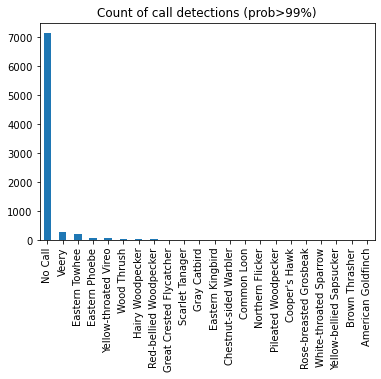

In [127]:
birds_df[birds_df['maxprob']>0.99]["bird"].value_counts().plot(kind='bar',title='Count of call detections (prob>99%)');

In [103]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,):
    display(pd.DataFrame(birds_df[birds_df['maxprob']>0.9]["bird"].value_counts(),columns = ["Common Name","Count(prob>90%)"]))

Empty DataFrame
Columns: [Common Name, Count(prob>90%)]
Index: []

In [104]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,):
    display(pd.DataFrame(birds_df[birds_df['maxprob']>0.99]["bird"].value_counts()))

bird
No Call                   51838
Great Crested Flycatcher     31
Black-capped Chickadee       20
Red-bellied Woodpecker       11
American Goldfinch           10
House Finch                   8
Eastern Phoebe                5
Common Grackle                3
Hairy Woodpecker              2
Downy Woodpecker              2
Pileated Woodpecker           2
Broad-winged Hawk             2
Cooper's Hawk                 1
Brown-headed Cowbird          1
Northern Flicker              1

In [106]:
df = birds_df[birds_df['maxprob']>0.99]["bird"].value_counts().to_frame().reset_index()
df.columns = ["Common Name", "Count (prob>90%)"]
df

Common Name  Count (prob>90%)
0                    No Call             51838
1   Great Crested Flycatcher                31
2     Black-capped Chickadee                20
3     Red-bellied Woodpecker                11
4         American Goldfinch                10
5                House Finch                 8
6             Eastern Phoebe                 5
7             Common Grackle                 3
8           Hairy Woodpecker                 2
9           Downy Woodpecker                 2
10       Pileated Woodpecker                 2
11         Broad-winged Hawk                 2
12             Cooper's Hawk                 1
13      Brown-headed Cowbird                 1
14          Northern Flicker                 1

## Identify time locations of best sample reflected for each bird (highest prob)

## Listen to some of the bird samples

In [264]:
def bird_sound(bird_common_name, birds_df, num=10, prob=0.99):
    sel = (birds_df['maxprob']>prob) & (birds_df['bird'] == bird_common_name)
    
    birds_selected = birds_df[sel]
    
    avail_ct = birds_selected.shape[0]
    
    #sort in order starting with most probability
    bird_sorted = birds_selected.sort_values("maxprob",ascending=False)
    
    with pd.option_context('display.max_rows', None,'display.max_columns', None,):
        display(bird_sorted[0:num])
    
    for i in range(0,min(avail_ct,num)):
        #b = birds_df[sel].iloc[i]
        b = bird_sorted.iloc[i]
        print(i,b["bird"],"probability:", b["maxprob"])
        print("File:",b["file"])
        print("Time(sec):",b["time"])
        t_start = b['time']-5
        t_length = 10
        
        x, sr = torchaudio.load(b["file"], int((t_start)*48000), t_length*48000)
        #plot_specgram(x, sr, title=b['bird'], xlim=None)
        play_audio(x, sr)
        
        
        #  Show all animals in the clip
        
        sel = (birds_df['file'] == b['file']) & (birds_df['time']>=t_start) & (birds_df['time']<t_start+t_length) & (birds_df['bird'] != 'No Call')
        
        unique_birds = birds_df[sel& (birds_df['maxprob']>=prob)  ]['bird'].unique()
        
        sel = sel & (birds_df['bird'].isin(unique_birds))
        
        sample_df = birds_df[sel][['bird','maxprob','time']].sort_values('time')
        sample_df['time_in_sample'] = (sample_df['time']-t_start) 
        #print(sample_df[['bird','time_in_sample','maxprob']])
        
        
        
        #bird_code = {}
        #for i, label in enumerate(sorted(unique_birds)):
        #    bird_code[label] = i
        
        #def bird_code_fn(bird_name):
        #    return bird_code[bird_name]

        #inv_bird_code = np.array(sorted(unique_birds))
        
        
        
        
        #xx = sample_df['bird'].apply(bird_code_fn)
        #yy = sample_df['time_in_sample']
        #res = sample_df['maxprob']
        
        
        
        fig, ax = plt.subplots(1,1,figsize=(12, 6))
        ax.title.set_text('Spectrogram of sample - '+b['bird'])

        ax.specgram(x[0].numpy(), Fs=sr)
        
        def indicator(row):
            if row['bird'] == bird_common_name:
                color = 'red'
                label = bird_common_name
            else:
                color = 'black'
                label = 'Other'
            #ax.axvline(x=row['time_in_sample'], color=row.index, cmap='Reds',linestyle='--', label=row['bird'])
            ax.axvline(x=row['time_in_sample'],c=color,linestyle=':', label=label)
            ax.text(x=.1+row['time_in_sample'],y= 12000, s=row['bird'], rotation=90, verticalalignment='center')
        
        sample_df.apply(indicator,axis = 1)
        #(yy).apply(ax.axvline)
        #ax[0].axvline(x=5)
        
        
        def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))
        
        
        legend_without_duplicate_labels(ax)
        plt.show()
        
        
        #plot_specgram(x[0].unsqueeze(0), sr, title=b['bird'], xlim=None)
    

file         time  \
156471  /media/HDD/Audio Recordings/Cabin/cabin July 4...  2713.157895   

       bird_key         bird  maxprob  
156471   comloo  Common Loon  0.99921

0 Common Loon probability: 0.999210238456726
File: /media/HDD/Audio Recordings/Cabin/cabin July 4 2021/schilling Pines-2021-07-03--09-33-08-20.flac
Time(sec): 2713.157894736842


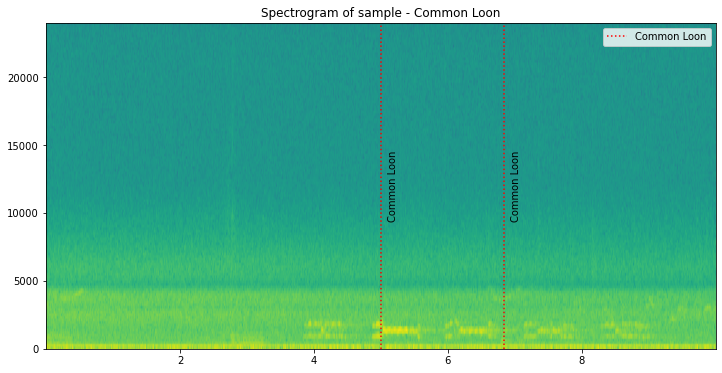

In [269]:
bird_sound(bird_common_name="Common Loon", birds_df=birds_df, num=1, prob=0.7)

In [178]:
birds_df.sort_values("time")[0:20]

file  time bird_key  \
0       /media/HDD/Audio Recordings/Cabin/Cabin Aug 28...   0.0   heptan   
353844  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   
361232  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   orcwar   
364926  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   balori   
369210  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   
786166  /media/HDD/Audio Recordings/Cabin/Cabin Sept 1...   0.0  no_call   
381558  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   
385397  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   grcfly   
778860  /media/HDD/Audio Recordings/Cabin/Cabin Sept 1...   0.0  no_call   
135837  /media/HDD/Audio Recordings/Cabin/cabin July 4...   0.0   whtdov   
389550  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   acafly   
775622  /media/HDD/Audio Recordings/Cabin/Cabin Sept 1...   0.0  andsol1   
389553  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   scatan   
393428  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   
766103  /media/HDD/Audio Recordings/Cabin/Cabin Sept 1...   0.0  littin1   
403732  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   
408319  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   acafly   
408322  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0   mouwar   
408324  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  reevir1   
410491  /media/HDD/Audio Recordings/Cabin/cabin July 9...   0.0  no_call   

                            bird   maxprob  
0                Hepatic Tanager  0.795376  
353844                   No Call  0.252852  
361232    Orange-crowned Warbler  0.275395  
364926          Baltimore Oriole  0.546060  
369210                   No Call  0.250241  
786166                   No Call  0.252846  
381558                   No Call  0.251480  
385397  Great Crested Flycatcher  0.875458  
778860                   No Call  0.254946  
135837         White-tipped Dove  0.469525  
389550        Acadian Flycatcher  0.424292  
775622          Andean Solitaire  0.349706  
389553           Scarlet Tanager  0.432147  
393428                   No Call  0.251089  
766103            Little Tinamou  0.468173  
403732                   No Call  0.253978  
408319        Acadian Flycatcher  0.370054  
408322          Mourning Warbler  0.381179  
408324            Red-eyed Vireo  0.334893  
410491                   No Call  0.250852

In [394]:
#Make this work with 5 sec samples and a model
def plot_pred_file(file, ts,k, label_fn):

    idx=0
    x, sr = torchaudio.load(file, int((ts)*48000), 5*48000)
    new_model[0] = torchaudio.transforms.Resample(sr,48000)
    play_audio(x,sr)
    x = x[0].unsqueeze(0).unsqueeze(0).cuda()
    
    with torch.no_grad():
        outpt = new_model(x)
    
    
    waveform = x.cpu().squeeze(0)
    sample_rate = sr
    

    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    
    top_k_clip = outpt['clipwise_output'][idx].topk(k)
    
    
    
    print("Clipwise Prediction Info")
    print(top_k_clip.values.cpu())
    #print(list(map(label_fn,top_k_clip.indices.cpu())))
    print(list(map(label_fn,top_k_clip.indices.cpu().tolist())))

    top_k_frame = outpt['framewise_output'][idx].topk(1).indices.cpu()
    t=top_k_frame.unique().numpy()
    t_labels = list(map(label_fn,t))
    #t_labels = t
    data2D = outpt['framewise_output'][idx].cpu().detach().numpy().transpose()


    print(data2D[400,:])

    
    
    

    
    
    
    fig, ax = plt.subplots(2,1,figsize=(12, 12))
    #plt.rcParams["figure.figsize"] = [7.00, 3.50]
    #plt.rcParams["figure.autolayout"] = True

    ax[0].specgram(waveform[0], Fs=sample_rate)

    im = ax[1].imshow(data2D[t,:], cmap="copper")
    #plt.colorbar(im)
    ax[1].set_yticks(range(0,len(t_labels)))
    ax[1].set_yticklabels(t_labels)
    plt.show()

(1, 240000)
Clipwise Prediction Info
tensor([0.2504, 0.1696, 0.1280, 0.1067, 0.0920])
['No Call', 'Dark-eyed Junco', 'Chipping Sparrow', 'Black-capped Chickadee', 'Indigo Bunting']
[2.1064036e-05 2.9520734e-06 5.0911757e-07 3.8173795e-07 8.1294473e-08
 3.9500019e-08 1.6678371e-08 2.4340874e-08 7.9300044e-08 1.7851613e-07
 4.9338126e-07 1.9322070e-07 3.6662289e-08 4.0756991e-08 9.6126897e-08
 4.2603898e-07 8.6896900e-05 1.1005476e-05 1.8275043e-05]


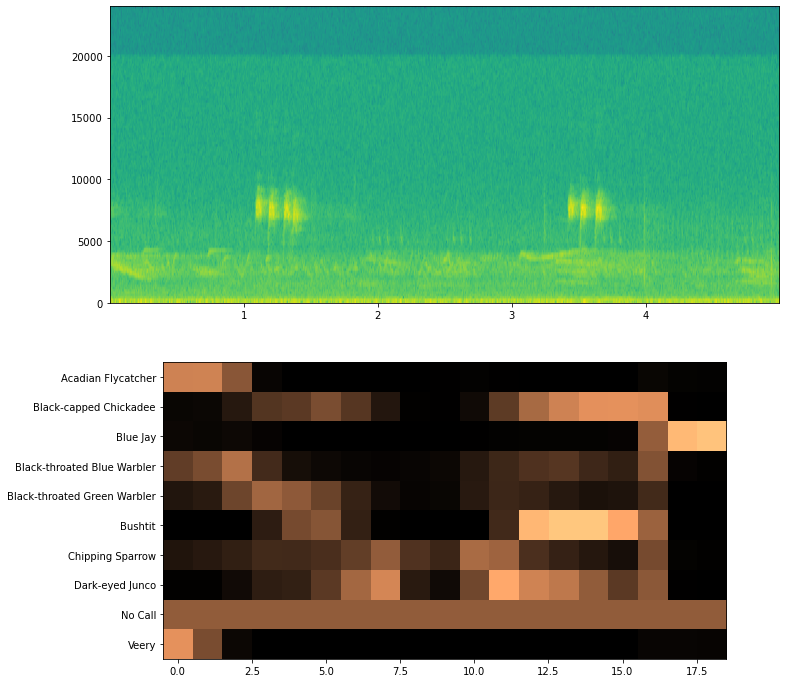

In [423]:
plot_pred_file('/media/HDD/Audio Recordings/Cabin/cabin July 9 2021/field friday-2021-07-10--05-39-18-10.opus',
               3340, 5,
               bird_common)

(1, 240000)
Clipwise Prediction Info
tensor([0.8624, 0.2588, 0.0193, 0.0115, 0.0028])
['Coyote', 'No Call', 'Laughing Falcon', 'Crested Guan', 'Herring Gull']
[4.9859419e-01 5.1100028e-01 6.3863331e-01 8.0199194e-01 9.0653884e-01
 9.2460448e-01 9.0312076e-01 7.7248389e-01 5.3743732e-01 1.8248466e-01
 5.8335703e-02 1.2757572e-02 3.8189576e-03 5.5633619e-04 2.3846896e-04
 1.7223474e-04 1.6606983e-04 1.7604663e-04 1.1718163e-04]


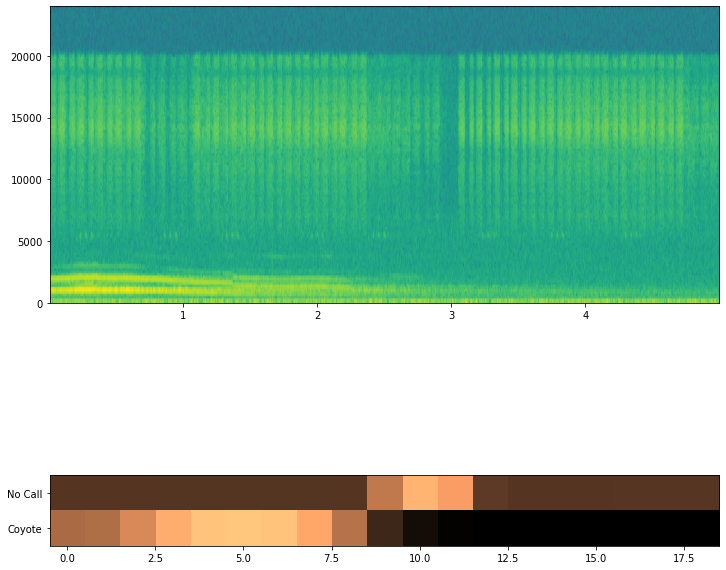

In [420]:
plot_pred_file('/media/HDD/Audio Recordings/Cabin/cabin July 9 2021/field friday-2021-07-09--21-39-16-2.opus',
               1372, 5,
               bird_common)

## Find a bird call in the recordings that best matches the bird

In [165]:
sel = (birds_df['bird'] == "Veery")
i=birds_df[sel]['maxprob'].argmax()

In [159]:
i=0

In [166]:
b = birds_df[sel].iloc[i]

In [167]:
x, sr = torchaudio.load(b["file"], int((b['time']-5)*48000), 10*48000)
play_audio(x, sr)

In [154]:
birds_df[sel].shape

(25, 4)

In [230]:
display(birds_df[sel])

file         time  \
468203  /media/HDD/Audio Recordings/Cabin/Cabin May 31...   785.526316   
580865  /media/HDD/Audio Recordings/Cabin/Early Spring...  3127.894737   
581252  /media/HDD/Audio Recordings/Cabin/Early Spring...  3563.684211   
583410  /media/HDD/Audio Recordings/Cabin/Early Spring...  2790.263158   
583433  /media/HDD/Audio Recordings/Cabin/Early Spring...  2815.789474   

                        bird   maxprob  
468203  Brown-headed Cowbird  0.999440  
580865  Brown-headed Cowbird  0.999966  
581252  Brown-headed Cowbird  0.996136  
583410  Brown-headed Cowbird  0.998898  
583433  Brown-headed Cowbird  0.996446

In [ ]:
#dataset = Dataset_from_df(df,'/media/SSD/Sound Detection',5*32000)
#testset = Dataset_from_df_seg(pred_df,'',5*48000,19)
testset = Dataset_from_df_seg(pred_df,bird_key,'',5*48000,19,no_labels=True)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset=testset,
                                               batch_size=16,
                                               num_workers=12,
                                               pin_memory=True,
                                               shuffle=False)

In [ ]:
new_model[0] = torchaudio.transforms.Resample(48000, 48000)

In [ ]:
new_model.cuda();

In [ ]:
pbar = tqdm(total=len(test_dataloader))
r = []
for batch in test_dataloader:
    output, preds, y = predictfp32(batch,model=new_model[1:])
    for idx in range(0,16):
        d = {"labels":[],"probs":[]}
        
        #top_k_frame = output['framewise_output'][idx].topk(1).indices.cpu()
        #t=top_k_frame.unique().numpy()
        #t_labels = list(map(testset.lookup_key,t))
        #data2D = output['framewise_output'][idx].cpu().detach().numpy().transpose()
        #d['labels'] = t_labels
        #d['probs'] = data2D[t,:]
        #print(t_labels)
        #print(data2D[t,:])
        #r.append(d)
    pbar.update(1)
pbar.close()

In [ ]:
t = []
for row in r:
    if row['probs']
    

In [ ]:
r

In [ ]:
torchaudio.set_audio_backend("sox_io")
#torchaudio.set_audio_backend("soundfile")

In [ ]:
ct = 0
for batch in test_dataloader:
    output, preds, y = predictfp32(batch,model=new_model)
    for idx in range(0,16):
        top_k_clip = output['clipwise_output'][idx].topk(5)
        
        print("batch idx=",idx, "data idx=",batch[3][idx].item())
        
        print("Clipwise Prediction Info")
        print(top_k_clip.values.cpu().detach().numpy())
        print(top_k_clip.indices.cpu().numpy())
        print(list(map(bird_common,top_k_clip.indices.cpu().numpy())))
        
        
        plot_pred(batch, output, idx,label_fn=bird_common)
    ct = ct + 1
    if ct > 2:
        break

In [ ]:
torch.mean(batch[0],dim=1,keepdim=True).shape

In [ ]:
import sqlite3

In [ ]:
sql_con = sqlite3.connect('test.db')

In [ ]:
sql_cur = sql_con.cursor()

In [ ]:
table = """ CREATE TABLE register
        (path text,id text, channels integer, sample_len integer, sample_rate integer);
        """

In [ ]:
sql_cur.execute(table)

In [ ]:
sql_con.commit()

In [ ]:
sql_con.close()

In [ ]:
cmd = "PRAGMA journal_mode=WAL;"
sql_con = sqlite3.connect('test.db')
sql_cur = sql_con.cursor()
sql_cur.execute(cmd)
sql_con.commit()
sql_con.close()

In [ ]:
batch = next(iter(full_dataloader)) 
output, preds, y = predictfp32(batch,model=new_model)

In [ ]:
play_audio(batch[0][0], 32000)

In [ ]:
bird_common(batch[2][0].argmax(axis=0))

In [ ]:
bird_common(output["clipwise_output"][0].argmax(axis=0))

In [ ]:
output["clipwise_output"][0].max(axis=0)

In [ ]:
output["framewise_output"][0].max(axis=1)

In [320]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

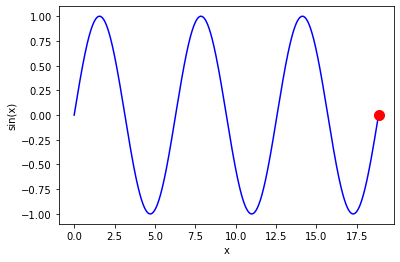

In [321]:
n = 1000
x = np.linspace(0, 6*np.pi, n)
y = np.sin(x)

# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

# Initialize the movie
fig = plt.figure()

# plot the sine wave line
sine_line, = plt.plot(x, y, 'b')
red_circle, = plt.plot([], [], 'ro', markersize = 10)
plt.xlabel('x')
plt.ylabel('sin(x)')

# Update the frames for the movie
with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(n):
        x0 = x[i]
        y0 = y[i]
        red_circle.set_data(x0, y0)
        writer.grab_frame()



In [322]:
# don't worry about the code in this cell, it is just to let you 
# display the movies you generated above in Jupyter notebook
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="writer_test.mp4" type="video/mp4">
</video></div>""")
